In [646]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sintgr

## Project Schrödinger

This notebook was computed by Linda Muller et Camille Robert for the course "Numerical Simulations" in the context of the second semester of the M1 - Fundamental Physics at the University of Strasbourg, Faculty of Physics and Engineering, 2023.

The chosen topic is Subject 1: Project Schrödinger, which aims to study the numerical solutions to the 1-D time-independent Schrödinger equation.

### 1. Analytical Test: Particle in a 1-D Box 

In [647]:
#discretizing the solution space (x,Ψ(x))
#--
L = 1.0                     #length of the box: L = 1
N = 5000                    #number of points on the grid
step = L/N                  #grid spacing
x = np.linspace(0,L,N)      #discretized x-axis

In [648]:
#defining the constants
#--
h = 6.62607015*(10**(-34))  #Planck constant in kg m² /s 
hbar = h/(2*np.pi)          #reduced Planck constant in kg m² /s 
m = 9.10938370*(10**(-31))  #mass of an electron in kg
E1 = (h**2)/(8*m*L**2)      #analytical ground-state energy for a particle in a 1-D box
V0 = 1.0                    #depth of the potential well

In [649]:
#introducing dimensionless quantities
#--
gamma2 = 2000

In [650]:
#define the potential
#--
def box_potential(x):
    return np.where(np.logical_and(x > 0.0, x < 1.0), V0, 1e10) 

In [651]:
#implement the function that finds the wave function
#--
def find_psi(epsilon) :
    
    #create an array containing g(x_i)
    g = np.zeros(N)
    for i in range(0,N):
        g[i] = gamma2*(epsilon-box_potential(x[i]))
    
    #define a array of zeros to contain the values of the wavefunction
    psi = np.zeros(N)
    #append the boundary condition on the left
    psi[0] = 0.0
    #append the guessed value for the second point on the grid
    psi[1] = step
    
    #propagate the solution with numerov
    for i in range(0,N-2):
        psi[i+2] = ((2*psi[i+1]*(1-5*((step**2)/12)*g[i+1])) - (psi[i]*(1+((step**2)/12)*g[i])))/(1 + ((step**2)/12)*g[i+2])

    #return an array containing the values of the wavefunction for each point on the grid
    return psi

In [652]:
#find the first wave function by using the analytical energy for the ground state
#--
epsilon = 1.0049367767116046
psi = find_psi(epsilon)

#check that the last point is close to zero
psi[-1]                                   

-2.063087290928097e-15

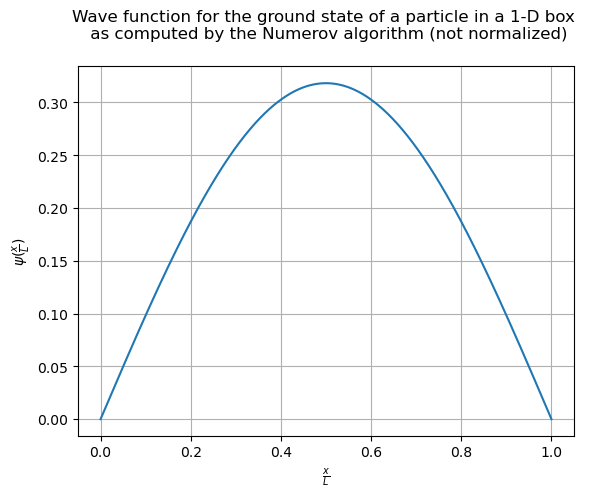

In [653]:
#plot the wave fuction computed by the Numerov algorithm to verify the boundary conditions
#--
plt.plot(x,psi)
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\psi(\frac{x}{L})$')
plt.title("Wave function for the ground state of a particle in a 1-D box \n as computed by the Numerov algorithm (not normalized)", pad=20)
plt.grid()
plt.show()

In [654]:
#define a function to compute the integral
#--
def newton_cotes(Nr, N, y, dx) :
    
    #recover the weights and the error associated with the order of interpolation
    #--
    w, e = sintgr.newton_cotes(Nr)
    
    #define a variable that will contain the sum over the integral
    #--
    s = 0.
    
    #calculate the integral
    #--
    for i in range(0, N-Nr, Nr):
        s += w.dot((y[i:i+Nr+1]))
        
    #return the value of the integral and the error
    #--
    result = s*dx
    return result, e

In [655]:
#define a function that normalizes the wave function
#--
def normalize(psi) : 
    
    #find the normalization constant
    psi2 = psi**2
    integral, error = newton_cotes(2, N, psi2, step)
    C = 1/integral
    
    #normalize the wave function
    psi *= np.sqrt(C)
    
    #return the normalized wave function
    return psi

In [656]:
#normalize the wave function
#--
normalized_psi = normalize(psi)

In [657]:
#verify normalization
#--
integral, error = newton_cotes(2, N, normalized_psi**2, step)
print(integral)

0.999999999999995


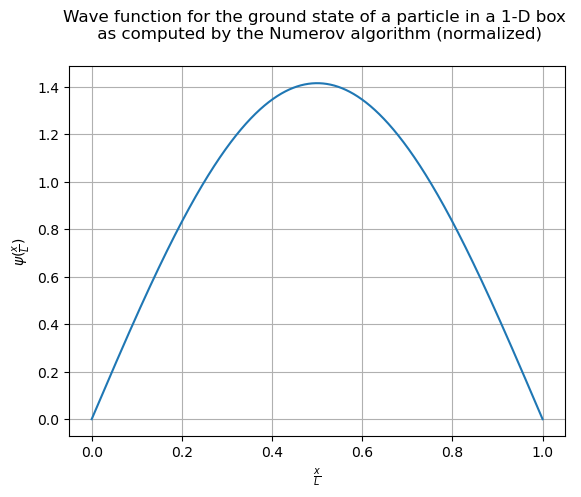

In [658]:
#plot the normalized solution as computed by the Numerov algorithm
#--
plt.plot(x,normalized_psi)
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\psi(\frac{x}{L})$')
plt.title("Wave function for the ground state of a particle in a 1-D box \n as computed by the Numerov algorithm (normalized)", pad=20)
plt.grid()
plt.show()

In [659]:
#define a function that computes the numerical value of the analytical solutions for the problem
#--
def analytical_solution(x,n,L,C):
    return C*np.sin(n*np.pi*x/L)

In [660]:
#compute the analytical solution for the ground state n = 1
#--
n = 1.0
C = np.sqrt(2)
analytical_psi = analytical_solution(x,n,L,C)

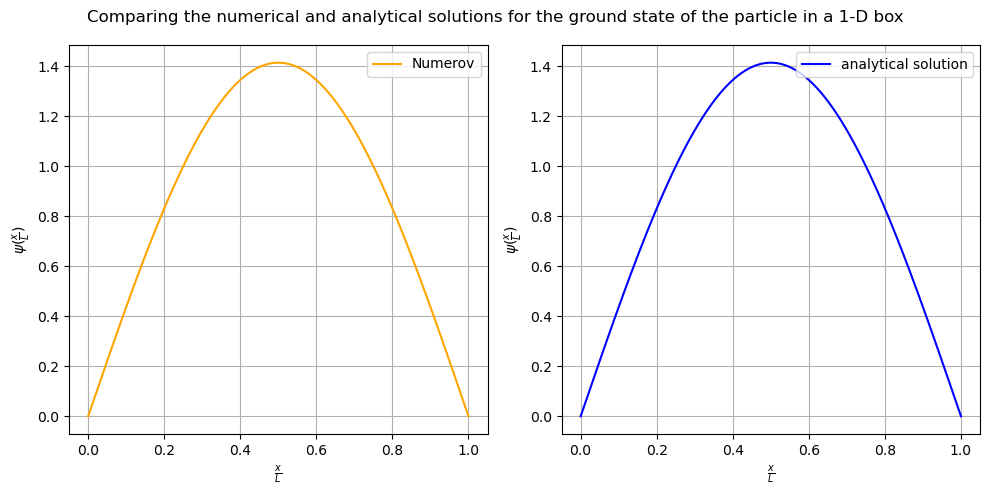

In [661]:
#compare the analytical solution and the Numerov solution
#--
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Comparing the numerical and analytical solutions for the ground state of the particle in a 1-D box")

ax1.plot(x,psi, color="orange", label="Numerov")
ax2.plot(x,analytical_psi, color="blue", label="analytical solution")
ax1.set_xlabel(r'$\frac{x}{L}$')
ax1.set_ylabel(r'$\psi(\frac{x}{L})$')
ax2.set_xlabel(r'$\frac{x}{L}$')
ax2.set_ylabel(r'$\psi(\frac{x}{L})$')
ax1.grid()
ax2.grid()
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [662]:
#define a fonction that finds the allowed energy levels by using the overshooting method
#--
def find_energy(epsilon, d_epsilon):

    psi1 = find_psi(epsilon)
    epsilon = epsilon+d_epsilon
    
    #the loops runs until the desired precision is attained 
    while(abs(d_epsilon) > 1e-12):
        
        psi2 = find_psi(epsilon)
   
        #this condition ensures that we have found an over/undershoot, i.e. that the sign of 
        #psi[-1] changes when ε becomes ε+dε
        if (psi1[-1]*psi2[-1] < 0): 
            d_epsilon = -d_epsilon/2

        epsilon = epsilon+d_epsilon
        psi1 = psi2
        
    return epsilon

In [663]:
#find the five first energy levels and wavefunctions
#--
eigenvalues = []
eigenfunctions = []

energy = find_energy(1.001, 0.001) #start looking for energies just a little above V0 = 1.0
psi = find_psi(energy)
eigenvalues.append(energy)
eigenfunctions.append(psi)

for i in range(4) :
    energy = find_energy(energy+0.001, 0.001)
    psi = find_psi(energy)
    eigenvalues.append(energy)
    eigenfunctions.append(psi)

In [664]:
#print the list of computed eigenvalues
#--
eigenvalues

[1.0049367767116046,
 1.0197471068538702,
 1.0444309904249331,
 1.0789884274173438,
 1.1234194178404149]

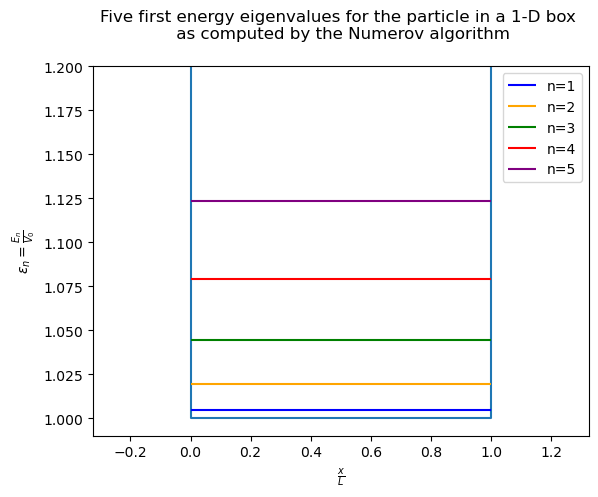

In [665]:
#plot the five first energy eigenvalues
#--

#define a new x-axis
new_x = np.linspace(-0.25, 1.25, 1000)

#draw the box
plt.plot(new_x, box_potential(new_x))

#create a list of colors
color_list = ['blue', 'orange', 'green', 'red', 'purple']

#draw the energies
for i in range(5):
    plt.hlines(eigenvalues[i], 0.0, 1.0, color=color_list[i], label=f"n={i+1}")

#set the graph options
plt.ylim(0.99, 1.20)
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\epsilon_n = \frac{E_n}{V_0}$')
plt.legend()
plt.title("Five first energy eigenvalues for the particle in a 1-D box \n as computed by the Numerov algorithm", pad=20)
plt.show()

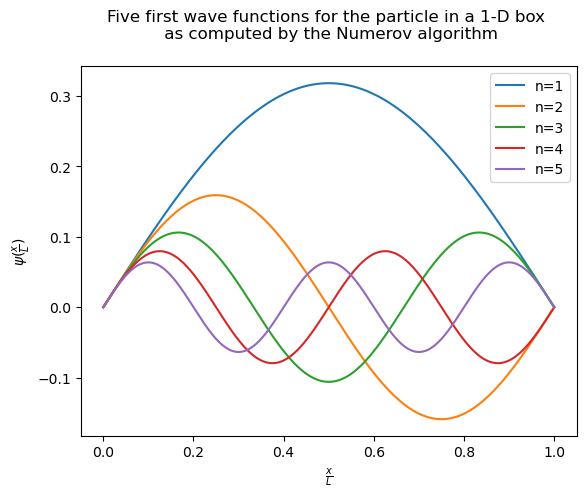

In [666]:
#plot the five first eigenfunctions
#--
for i in range(5):
    plt.plot(x, eigenfunctions[i], label=f"n={i+1}")

#set the graph options
plt.xlabel(r'$\frac{x}{L}$')
plt.ylabel(r'$\psi(\frac{x}{L})$')
plt.legend()
plt.title("Five first wave functions for the particle in a 1-D box \n as computed by the Numerov algorithm", pad=20)
plt.show()

### 2. Quantum Harmonic Oscillator

In [667]:
#discretize the solution space (x,Ψ(x))
#--
x_left  = -3                           #boundary condition on the left: x << -sqrt(2ε)
x_right = 3                            #boundary condition on the right: x >> sqrt(2ε)
N = 5000                               #number of points on the grid
step = (x_right-x_left)/N              #grid spacing
xx = np.linspace(x_left,x_right,N)     #discretized x-axis

In [668]:
#define the potential
#--
def harmonic_potential(x):
    return x**2

In [669]:
#define a function that finds psi_left and psi_right for a given epsilon
#--
def find_psi_left_right(epsilon) :
        
    #define a array of zeros to contain the values of the wavefunctions
    psi_left = np.zeros(N)
    psi_right = np.zeros(N)
    
    #append the boundary conditions
    psi_left[0] = 0.0
    psi_right[N-1] = 0.0
    
    #append the guessed value for the second point on the grid
    psi_left[1] = step
    psi_right[N-2] = step
    
    #create an array containing g(x_i)
    g = np.zeros(N)
    for i in range(0,N):
        g[i] = (2*epsilon)-(harmonic_potential(xx[i]))
    
    #propagate the solution with Numerov from the left towards x = 0
    for i in range(0,N-2):
        psi_left[i+2] = ((2*psi_left[i+1]*(1-5*((step**2)/12)*g[i+1])) - (psi_left[i]*(1+((step**2)/12)*g[i])))/(1 + ((step**2)/12)*g[i+2])
    
    #propagate the solution with Numerov from the right towards x = 0
    for j in range(N-1,1,-1):
        psi_right[j-2] = ((2*psi_right[j-1]*(1-5*((step**2)/12)*g[j-1])) - (psi_right[j]*(1+((step**2)/12)*g[j])))/(1 + ((step**2)/12)*g[j-2])
            
    #return an array containing the values of the wavefunctions for each point on the grid
    return psi_left, psi_right

In [670]:
#define the function to compute the total solution
#--
def find_psi_tot(psi_left, psi_right, n):
    
    #normalise the wavefunctions
    psi_left  = normalize(psi_left)
    psi_right = normalize(psi_right)
    
    #define a matching point at x = 0
    x_match = np.argmin(np.abs(xx))
    
    #create an array to hold the final wavefunction
    psi_tot = np.zeros(N)
    
    #if the solution is symmetrical...
    if (n%2 == 0):
        psi_tot[:x_match+1] = psi_left[:x_match+1]
        psi_tot[x_match:] = psi_right[x_match:]
        
    #if the solution is asymmetrical...
    else :
        psi_tot[:x_match+1] = -psi_left[:x_match+1]
        psi_tot[x_match:] = psi_right[x_match:]
        
    return psi_tot

In [671]:
#test the validity of the code for the known ground state solution
#--
n = 0
epsilon = 0.5
psi_left, psi_right = find_psi_left_right(epsilon)
psi_tot = find_psi_tot(psi_left, psi_right, n)

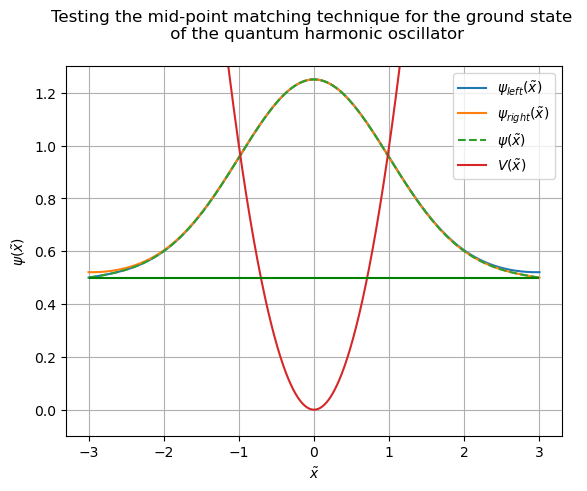

In [672]:
#plot the solution to test the code
#--
plt.plot(xx, psi_left+0.5, label=r'$\psi_{left}(\tilde{x})$')
plt.plot(xx, psi_right+0.5, label=r'$\psi_{right}(\tilde{x})$')
plt.plot(xx, psi_tot+0.5, label=r'$\psi(\tilde{x})$', linestyle='dashed')
plt.plot(xx, harmonic_potential(xx), label=r'$V(\tilde{x})$')
plt.hlines(0.5, -3.0, 3.0, color='green')
plt.title("Testing the mid-point matching technique for the ground state \n of the quantum harmonic oscillator", pad=20)
plt.xlabel(r'$\tilde{x}$')
plt.ylabel(r'$\psi(\tilde{x})$')
plt.ylim(-0.1, 1.3)
plt.legend()
plt.grid()
plt.show()

In [673]:
#define a function to calculate the slope of psi at a the matching point
#--
def slope(psi):
    return (psi[x_match+1] - psi[x_match])/step    

In [680]:
#define a fonction that finds the allowed energy levels by using the point-matching method for the slopes
#--
def match_slopes(epsilon, d_epsilon):

    #propagate the wave functions from the left and from the right
    psi_left, psi_right = find_psi_left_right(epsilon)
    
    #define a matching point
    x_match = np.argmin(np.abs(xx))
    
    #compute the slope at the matching point
    slope_left = slope(psi_left)
    slope_right = slope(psi_right)
    
    #calculate the difference between the slopes
    difference = abs(slope_left - slope_right)
    
    #the loops runs until an approximate solution is found
    while(difference > 1e-1):
        epsilon += d_epsilon
        psi_left, psi_right = find_psi_left_right(epsilon)
        slope_left = slope(psi_left)
        slope_right = slope(psi_right)
        difference = abs(slope_left - slope_right)
    
    #fine tune the approximate solution until the desired precision is attained
    while(d_epsilon > 1e-12):
        epsilon += d_epsilon
        psi_left, psi_right = find_psi_left_right(epsilon)
        slope_left = slope(psi_left)
        slope_right = slope(psi_right)
        new_difference = abs(slope_left - slope_right)
        
        #if the difference is larger than before, dε was too big so we cut it in half
        if (new_difference > difference):
            #subtract the old dε
            epsilon -= d_epsilon
            #cut dε in half
            d_epsilon = d_epsilon/2
        
        #if the difference is smaller than before, keep it 
        else :
            difference = new_difference
  
    return epsilon+d_epsilon

In [681]:
#define a fonction that finds the allowed energy levels by using the point-matching method for the values at the matching point
#--
def match_values(epsilon, d_epsilon):

    #propagate the wave functions from the left and from the right
    psi_left, psi_right = find_psi_left_right(epsilon)
    
    #define a matching point
    x_match = np.argmin(np.abs(xx))

    #the loops runs until there is a sign change between psi_left and psi_right a little before the matching point
    while(psi_left[x_match-100]*psi_right[x_match-100] > 0):
        epsilon += d_epsilon
        psi_left, psi_right = find_psi2(epsilon)
 
    #caclulate the difference in the values before and after the matching point
    difference = abs(psi_left[x_match-1] - psi_right[x_match+1])
    
    #fine tune the value of epsilon
    while(d_epsilon > 1e-12):
        epsilon += d_epsilon
        psi_left, psi_right = find_psi_left_right(epsilon)
        new_difference = abs(psi_left[x_match-1] - psi_right[x_match+1])
 
        #if the difference is larger than before, dε was too big so we cut it in half
        if (new_difference > difference):
            #subtract the old dε
            epsilon -= d_epsilon
            #cut dε in half
            d_epsilon = d_epsilon/2
        
        #if the difference is smaller than before, keep it 
        else :
            difference = new_difference
  
    return epsilon+d_epsilon

In [698]:
#find the five six energy eigenvalues
#--
n = [0,1,2,3,4,5,6]
eigenvalues = []
eigenfunctions = []
epsilon = 0.1
d_epsilon = 0.01

for i in range (len(n)):

    #if the order is even, we match the slopes
    if (n[i]%2 == 0):
        epsilon = match_slopes(epsilon, d_epsilon)
        eigenvalues.append(epsilon)
        psi_left, psi_right = find_psi_left_right(epsilon)
        psi_tot = find_psi_tot(psi_left, psi_right, n[i])
        eigenfunctions.append(psi_tot)
        epsilon += 0.5 
        
    #if the order is odd, we match the values
    else :
        epsilon = match_values(epsilon, d_epsilon)
        eigenvalues.append(epsilon)
        psi_left, psi_right = find_psi_left_right(epsilon)
        psi_tot = find_psi_tot(psi_left, psi_right, n[i])
        eigenfunctions.append(psi_tot)
        epsilon += 0.5

In [713]:
#print the list of eigenvalues
#--
eigenvalues

[0.5006250000005824,
 2.545625000001154,
 4.955625000001695,
 6.045625000003429,
 8.255625000003976,
 9.59562500000454,
 12.635625000005069]

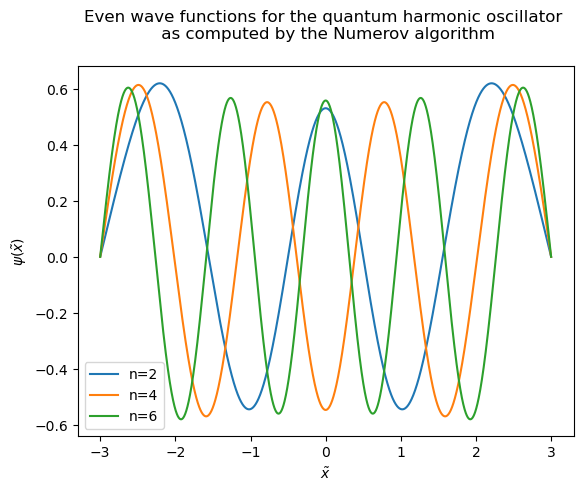

In [714]:
#plot the even eigenfunctions
#--
plt.plot(xx, eigenfunctions[2], label=f"n={2}")
plt.plot(xx, eigenfunctions[4], label=f"n={4}")
plt.plot(xx, eigenfunctions[6], label=f"n={6}")

#set the graph options
plt.xlabel(r'$\tilde{x}$')
plt.ylabel(r'$\psi(\tilde{x})$')
plt.legend()
plt.title("Even wave functions for the quantum harmonic oscillator \n as computed by the Numerov algorithm", pad=20)
plt.show()

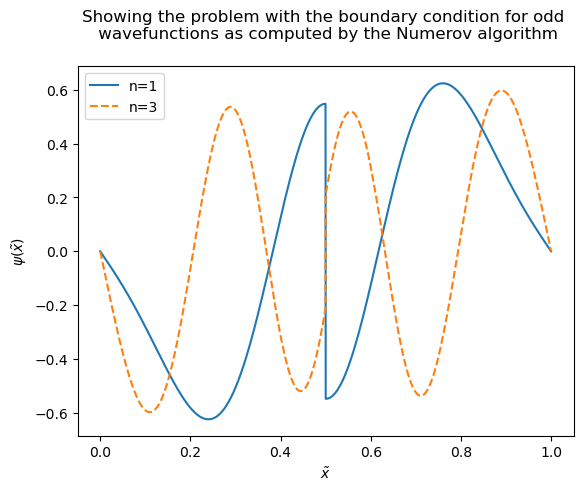

In [715]:
#plot the odd eigenfunctions
#--
plt.plot(x, eigenfunctions[1], label=f"n={1}")
plt.plot(x, eigenfunctions[3], label=f"n={3}", linestyle="dashed")
#plt.plot(x, eigenfunctions[5], label=f"n={5}")

#set the graph options
plt.xlabel(r'$\tilde{x}$')
plt.ylabel(r'$\psi(\tilde{x})$')
plt.legend()
plt.title("Showing the problem with the boundary condition for odd \n wavefunctions as computed by the Numerov algorithm", pad=20)
plt.show()